In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm
import cv2
import glob
import pickle

In [ ]:
paths = glob.glob('/content/drive/My Drive/RAFD/RAFD-front/*')

In [ ]:
emodic = {
    'angry' : 0,
    'disgusted' : 1,
    'fearful' : 2,
    'happy' : 3,
    'neutral' : 4,
    'sad' : 5,
    'surprised' : 6, 
    'contemptuous' : 7
}

In [ ]:
paths[10].split('/')[-1].split('_')[-2]

'angry'

In [ ]:
im = cv2.imread(paths[190])

In [ ]:
im.shape

(1024, 681, 3)

In [ ]:
im = im[100:-200,:]

In [ ]:
im = cv2.resize(im, (301,301))

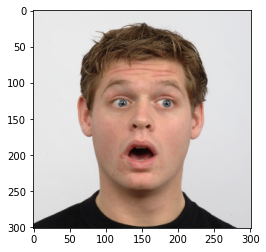

In [ ]:
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [ ]:
imgs = []
targets = []

for i in paths:
  label = i.split('/')[-1].split('_')[-2]
  ind = emodic[label]
  targets.append(ind)

  im = cv2.imread(i)
  im = im[100:-200,:]                  # crop
  im = cv2.resize(im, (301,301))       # resize
  imgs.append(im)

KeyboardInterrupt: ignored

In [ ]:
imgs = np.array(imgs)
targets = np.array(targets)

imgs.shape , targets.shape

In [ ]:
with open('/content/drive/My Drive/RAFD/dataset.obj','wb') as f:
  pickle.dump([imgs,targets],f)

---

In [ ]:
%pwd

'/content'

In [ ]:
with open('/content/drive/My Drive/dataset.obj','rb') as f:
  imgs, target = pickle.load(f)

In [ ]:
imgs = (imgs)/255.0
dataset = [imgs, target]

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Conv2DTranspose, Embedding, Reshape, Concatenate, Dropout , LeakyReLU
from tensorflow.keras.activations import relu
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
n_classes = 8
latent_dim = 100

In [ ]:
def get_descriminator(in_shape=(301,301,3), n_classes=8):

  label = Input(shape = (1,))
  li = Embedding(n_classes+1,50)(label)

  li = Dense(301*301*3)(li)

  li = Reshape((301,301,3))(li)

  image = Input(shape=in_shape)

  merge = Concatenate()([image, li])

  fe = Conv2D(128,(3,3), strides=(2,2), padding = 'same')(merge)
  fe = LeakyReLU()(fe)

  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU()(fe)

  fe = Flatten()(fe)
  fe = Dropout(0.4)(fe)

  out_layer = Dense(1, activation='sigmoid')(fe)

  model = Model([image, label], out_layer)

  opt = RMSprop(lr=0.0001)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
 
  return model


In [ ]:
def get_generator(latent_dim, n_classes = 8):

  d = 49
  label = Input(shape=(1,))

  li = Embedding(n_classes+1,50)(label)

  li = Dense(d * d)(li)
  li = Reshape((d,d,1))(li)

  latent = Input(shape=(latent_dim,))

  gen = Dense(128 * d * d)(latent)
  gen = LeakyReLU()(gen)
  gen = Reshape((d, d, 128))(gen)

  merge = Concatenate()([gen, li])

  gen = Conv2DTranspose(128, (4,4), strides=(3,3), padding='valid')(merge)
  gen = LeakyReLU()(gen)
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='valid')(gen)
  gen = LeakyReLU()(gen)
  gen = Conv2DTranspose(64, (4,4), strides=(1,1), padding='valid')(gen)
  gen = LeakyReLU()(gen)

  out_layer = Conv2D(3, (8,8), activation='sigmoid', padding='same')(gen)

  model = Model([latent, label], out_layer)
  return model

In [ ]:
def cgan(genmodel,discmodel):

  discmodel.trainable = False

  g_noise, g_label = genmodel.input
  g_output = genmodel.output

  cgan_output = discmodel([g_output, g_label])

  model = Model([g_noise, g_label], cgan_output)

  opt = RMSprop(lr=0.0001)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [ ]:
def generate_real_samples(dataset, n_samples):
	
	images, labels = dataset

	ix = np.random.randint(0, images.shape[0], n_samples)
	
	X, labels = images[ix], labels[ix]
	
	y = np.ones((n_samples))
	return [X, labels], y

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_classes=8):
	
	x_input = np.random.randn(latent_dim * n_samples)
	
	z_input = x_input.reshape(n_samples, latent_dim)
	
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]
 

def generate_fake_samples(generator, latent_dim, n_samples):
	
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	
	images = generator.predict([z_input, labels_input])
	
	y = np.zeros((n_samples))
	return [images, labels_input], y

In [ ]:
def plot(model,seed):
  
  predictions = genmodel(seed, training=False)

  fig = plt.figure(figsize=(20,10))

  for i in range(predictions.shape[0]):
      plt.subplot(1, 8, i+1, title=list(emodic.keys())[i])
    
      plt.imshow(cv2.cvtColor(predictions[i].numpy(), cv2.COLOR_BGR2RGB))
      plt.axis('off')
  plt.show()

In [ ]:
test_input,y=generate_latent_points(100, 8)
y=np.asarray([0,1,2,3,4,5,6,7])
seed = [test_input,y]

In [ ]:
def train(genmodel, discmodel, cganmodel, dataset, latent_dim, n_epochs=100, n_batch=8):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  d1=[]
  d2=[]
  g=[]
  for i in range(n_epochs):

    d1v = 0
    d2v = 0
    gv = 0

    
    for j in range(bat_per_epo):
      display.clear_output(wait=True)
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = discmodel.train_on_batch([X_real, labels_real], y_real)

      [X_fake, labels], y_fake = generate_fake_samples(genmodel, latent_dim, half_batch)
      d_loss2, _ = discmodel.train_on_batch([X_fake, labels], y_fake)

      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

      y_gan = np.ones((n_batch, 1))

      g_loss = cganmodel.train_on_batch([z_input, labels_input], y_gan)

      d1v += d_loss1
      d2v += d_loss2
      gv += g_loss
    
    d1v /= bat_per_epo
    d2v /= bat_per_epo
    gv  /= bat_per_epo

    d1.append(d1v)
    d2.append(d2v)
    g.append(gv)
      
    print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    
    plot(genmodel,seed)


    

    if i%100==0:

        genmodel.save_weights("/content/drive/My Drive/dl_proj/gen_model_last"+ str(i) + ".h5")
        discmodel.save_weights("/content/drive/My Drive/dl_proj/disc_model_last"+ str(i) + ".h5")
    

  return d1,d2,g
      


In [ ]:
discmodel = get_descriminator()
genmodel = get_generator(latent_dim)
cganmodel = cgan(genmodel,discmodel)

In [ ]:
d1,d2,g=train(genmodel, discmodel, cganmodel, dataset, latent_dim,n_epochs=2000)

>152, 60/60, d1=0.480, d2=0.687 g=2.230
Buffered data was truncated after reaching the output size limit.

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(15,10))
plt.plot(d1[:],label='D real Loss')
plt.plot(d2[:],label='D fake Loss')
plt.plot(g[:],label='G Loss')
plt.legend()
plt.text(150,5, "Lr : 0.0001 epochs : 1000")
plt.show()